In [1]:
import matplotlib.pyplot as plt
import tools.dataTools as dt
from constants import Constants
import figure_params
import os
import matplotlib.pyplot as plt
import pyaldata as pyal
import pickle
from tqdm.auto import tqdm
from textwrap import wrap
import numpy as np
from scipy.linalg import orth, null_space
from sklearn.linear_model import LinearRegression
import pandas as pd
from sklearn.decomposition import PCA

figure_params.set_rc_params
figure_params.setup_directories()

SUBFIG_DIR = Constants.FIG_FOLDER + 'figS3_variance/'
if not os.path.exists(SUBFIG_DIR):
    os.makedirs(SUBFIG_DIR)

# #run simulations for figure, will take a while to run
import subprocess
os.chdir(Constants.PROJ_DIR)
# subprocess.run(["bash", "simulation/fig_simulations/Sfig_synthetic_sims.sh"]) #uncomment code to make datasets if not made yet

import warnings
warnings.filterwarnings("ignore")

In [2]:
seeds = Constants.SEEDS
reps  = Constants.UNIS
seed_ex = Constants.SEED_EX

### For networks trained on synthetic trajectories

In [3]:
dataset = '_synth_fixed_rad'
sim_set = 'uni_synth_fixed_rad'

#### Target and model output 

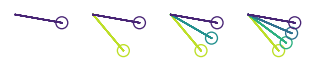

In [4]:
fig, axs = plt.subplots(ncols = len(reps))
for i, rep in enumerate(reps):
    ax = dt.graph_repertoire(dataset, rep, ax = axs[i], graph_all=False)
plt.savefig(SUBFIG_DIR + '/synth_target.pdf', format = 'pdf')

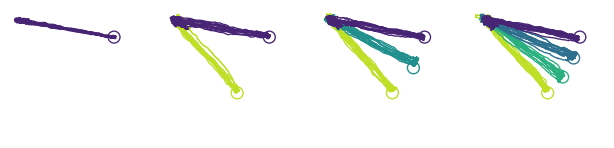

In [5]:
dt.graph_outputs_all(seed_ex, 'uni_synth_fixed_rad', reps)
plt.savefig(SUBFIG_DIR + '/synth_output.pdf', format = 'pdf')

#### Calculate comparison measures

In [6]:
datafile = 'uni_10.0_synth_fixed_rad'
redo = True
fname = Constants.PROCESSED_DATA_FOLDER + sim_set + '/'+ 'repertoire_comparison_measures_norm.pickle'
if os.path.isfile(fname) & (not redo):
    with open(fname, 'rb') as f:
        measures_df = pickle.load(f)
else:
    #calculate variance for unit activity, latent activity, position, and angle
    rows_list = []
    for seed in tqdm(seeds):
        for repertoire in reps:
            #get simulation data
            exec_df = dt.get_pyaldata(sim_set, seed, repertoire, epoch_fun = Constants.exec_epoch, 
                subtract_mean=False, datafile = datafile)
            exec_df = dt.perform_pca(exec_df, Constants.PCA_DIMS)
            prep_exec_df = dt.get_pyaldata(sim_set, seed, repertoire, epoch_fun = Constants.prep_exec_epoch, 
                subtract_mean=False, datafile = datafile)
            prep_exec_df = dt.perform_pca(prep_exec_df, Constants.PCA_DIMS)

            #calculate distances between timesteps (for normalization)
            av_df = pyal.trial_average(prep_exec_df, 'target_param')
            dist_tsteps = np.linalg.norm(np.diff(av_df.both_pca.values.tolist(), axis = 1),axis = 2)

            # output null/potent variance
            Y = pyal.concat_trials(prep_exec_df,'pos').T
            # calculate variance in output-null/potent spaces
            subspace_var = {}
            for signal in ['MCx_rates', 'both_pca']:
                centered_df = pyal.center_signal(prep_exec_df,signal)
                X = pyal.concat_trials(centered_df,signal).T
                lr = LinearRegression().fit(X.T, Y.T)
                W_potent = orth(lr.coef_.T)
                W_null = null_space(lr.coef_)

                prep_exec_df['null_'+signal] = [s @ W_null for s in centered_df[signal]]
                prep_exec_df['potent_'+signal] = [s @ W_potent for s in centered_df[signal]]

            #calculate variance #############
            var_rates = np.var(prep_exec_df.MCx_rates.values, axis = 0) #by timestep, across trials, per neuron
            var_rates_null = np.var(prep_exec_df.null_MCx_rates.values, axis = 0)
            var_rates_potent = np.var(prep_exec_df.potent_MCx_rates.values, axis = 0)
            var_pca = np.var(prep_exec_df.both_pca.values/np.median(dist_tsteps), axis = 0)
            var_pos = np.var(exec_df.pos.values, axis = 0)

            temp = {
                'seed': seed,
                'repertoire': repertoire,
                'var_rates': var_rates,
                'var_rates_null': var_rates_null,
                'var_rates_potent': var_rates_potent,
                'var_pca': var_pca,
                'var_pos': var_pos,
                'var_rates_total': var_rates.sum(axis =1),
                'var_rates_null_total': var_rates_null.sum(axis =1),
                'var_rates_potent_total': var_rates_potent.sum(axis =1),
                'var_pca_total': var_pca.sum(axis =1),
                'var_pos_total': var_pos.sum(axis =1),
            }
            rows_list.append(temp)

    measures_df = pd.DataFrame(rows_list)
    with open(fname, 'wb') as f:
        pickle.dump(measures_df, f)

  0%|          | 0/10 [00:00<?, ?it/s]

#### Variance in activity + output
Top: variance calculated for each feature for each time step across trials

Bottom: total variance summed across all features for each timestep across trials

0.0009765625
0.0009765625
0.9033203125
0.0009765625
0.0009765625
0.7216796875


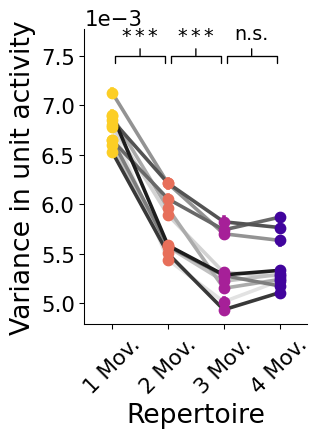

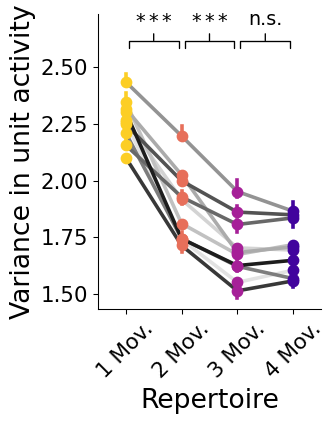

In [7]:
# variance in unit activity
measures_df['var_rates_flat'] = measures_df.apply(lambda x: x.var_rates.flatten(), axis = 1)

g = dt.compare_measure(measures_df, 'var_rates_flat', reps, stats_alternative = 'greater')
g.set_ylabel("\n".join(wrap('Variance in unit activity')))
plt.savefig(SUBFIG_DIR+ '/var_rates_all.pdf', format = 'pdf', bbox_inches = 'tight')

g = dt.compare_measure(measures_df, 'var_rates_total', reps, stats_alternative = 'greater')
g.set_ylabel("\n".join(wrap('Variance in unit activity')))
plt.savefig(SUBFIG_DIR+ '/var_rates_total.pdf', format = 'pdf', bbox_inches = 'tight')

0.9990234375
0.9970703125
0.9970703125
0.9345703125
0.5390625
0.986328125


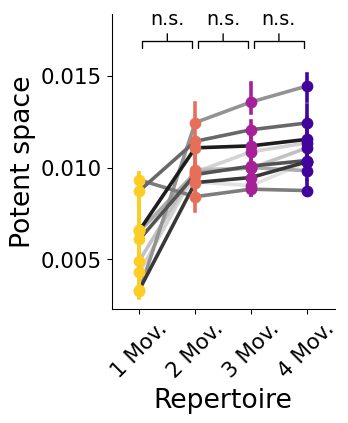

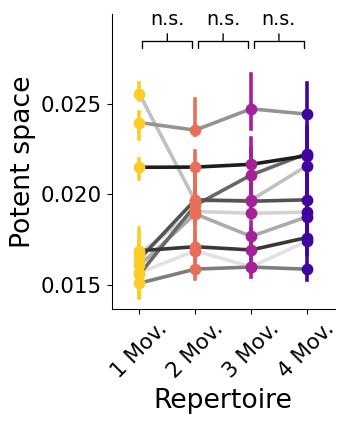

In [8]:
# variance in unit activity in output-potent space
measures_df['var_rates_potent_flat'] = measures_df.apply(lambda x: x.var_rates_potent.flatten(), axis = 1)

g = dt.compare_measure(measures_df, 'var_rates_potent_flat', reps, stats_alternative = 'greater')
g.set_ylabel("\n".join(wrap('Potent space')))
plt.savefig(SUBFIG_DIR+ '/var_rates_potent_all.pdf', format = 'pdf', bbox_inches = 'tight')

g = dt.compare_measure(measures_df, 'var_rates_potent_total', reps, stats_alternative = 'greater')
g.set_ylabel("\n".join(wrap('Potent space')))
plt.savefig(SUBFIG_DIR+ '/var_rates_potent_total.pdf', format = 'pdf', bbox_inches = 'tight')

0.0009765625
0.0009765625
0.8125
0.0009765625
0.0009765625
0.7216796875


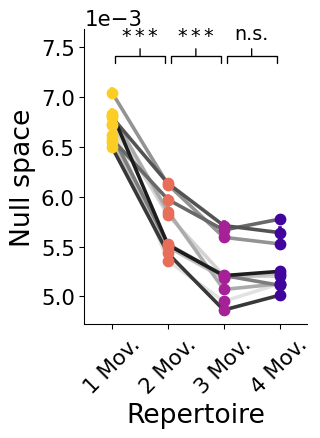

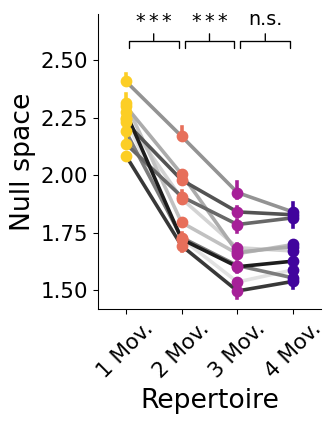

In [9]:
# variance in unit activity in output-null space
measures_df['var_rates_null_flat'] = measures_df.apply(lambda x: x.var_rates_null.flatten(), axis = 1)

g = dt.compare_measure(measures_df, 'var_rates_null_flat', reps, stats_alternative = 'greater')
g.set_ylabel("\n".join(wrap('Null space')))
plt.savefig(SUBFIG_DIR+ '/var_rates_null_all.pdf', format = 'pdf', bbox_inches = 'tight')

g = dt.compare_measure(measures_df, 'var_rates_null_total', reps, stats_alternative = 'greater')
g.set_ylabel("\n".join(wrap('Null space')))
plt.savefig(SUBFIG_DIR+ '/var_rates_null_total.pdf', format = 'pdf', bbox_inches = 'tight')

0.013671875
0.0009765625
0.8837890625
0.009765625
0.0009765625
0.615234375


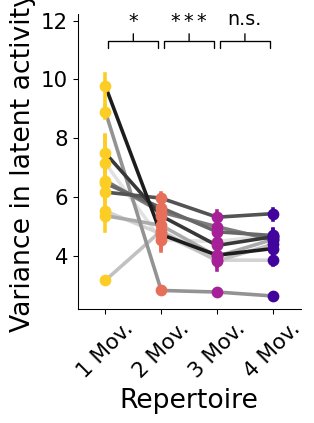

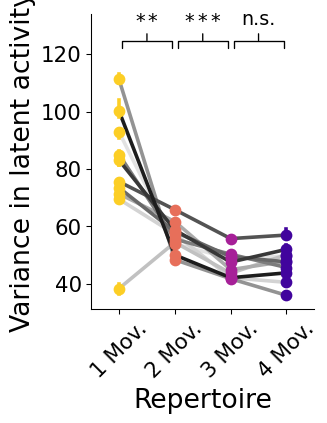

In [10]:
# variance in latent activity
measures_df['var_pca_flat'] = measures_df.apply(lambda x: x.var_pca.flatten(), axis = 1)
measures_df['var_pca_total'] = measures_df.apply(lambda x: x.var_pca.sum(axis =1), axis = 1)

g = dt.compare_measure(measures_df, 'var_pca_flat', reps, stats_alternative = 'greater')
g.set_ylabel("\n".join(wrap('Variance in latent activity')))
plt.savefig(SUBFIG_DIR+ '/var_pca_all.pdf', format = 'pdf', bbox_inches = 'tight')

g = dt.compare_measure(measures_df, 'var_pca_total', reps, stats_alternative = 'greater')
g.set_ylabel("\n".join(wrap('Variance in latent activity')))
plt.savefig(SUBFIG_DIR+ '/var_pca_total.pdf', format = 'pdf', bbox_inches = 'tight')


0.0009765625
0.0009765625
0.0009765625
0.009765625
0.0068359375
0.0068359375


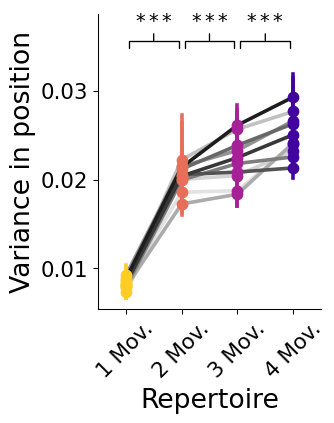

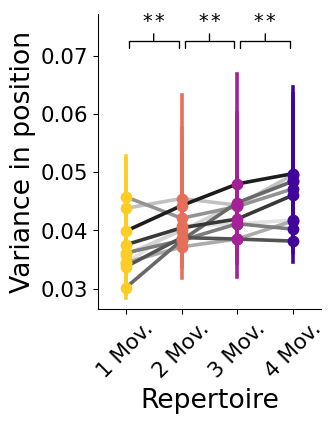

In [11]:
# variance in position
measures_df['var_pos_flat'] = measures_df.apply(lambda x: x.var_pos.flatten(), axis = 1)
measures_df['var_pos_total'] = measures_df.apply(lambda x: x.var_pos.sum(axis =1), axis = 1)

g = dt.compare_measure(measures_df, 'var_pos_flat', reps, stats_alternative = 'less')
g.set_ylabel("\n".join(wrap('Variance in position')))
plt.savefig(SUBFIG_DIR+ '/var_position_all.pdf', format = 'pdf', bbox_inches = 'tight')

g = dt.compare_measure(measures_df, 'var_pos_total', reps, stats_alternative = 'less')
g.set_ylabel("\n".join(wrap('Variance in position')))
plt.savefig(SUBFIG_DIR+ '/var_position_total.pdf', format = 'pdf', bbox_inches = 'tight')


### For networks trained on actual (experimental) trajectories

In [12]:
dataset = '_rad'
sim_set = 'uni_rad'

#### Target and model output 

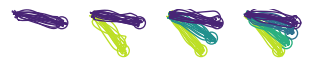

In [13]:
fig, axs = plt.subplots(ncols = len(reps))
for i, rep in enumerate(reps):
    ax = dt.graph_repertoire(dataset, rep, ax = axs[i], graph_all=False)
plt.savefig(SUBFIG_DIR + '/exp_target.pdf', format = 'pdf')

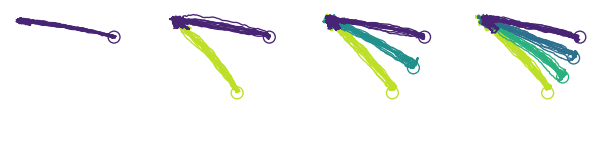

In [14]:
dt.graph_outputs_all(seed_ex, sim_set, reps)
plt.savefig(SUBFIG_DIR + '/exp_output.pdf', format = 'pdf')

#### Calculate comparison measures

In [15]:
datafile = 'uni_10.0_rad'
redo = False

fname = Constants.PROCESSED_DATA_FOLDER + sim_set + '/'+ 'total_variance.pickle'
if os.path.isfile(fname) & (not redo):
    with open(fname, 'rb') as f:
        measures_df = pickle.load(f)
else:
    #calculate variance for unit activity, latent activity, position, and angle
    rows_list = []
    for seed in tqdm(seeds):
        for repertoire in reps:
            #get simulation data
            exec_df = dt.get_pyaldata(sim_set, seed, repertoire, epoch_fun = Constants.exec_epoch, 
                subtract_mean=False, datafile = datafile, calculate_kinematics=True)
            exec_df = dt.perform_pca(exec_df, Constants.PCA_DIMS)
            prep_exec_df = dt.get_pyaldata(sim_set, seed, repertoire, epoch_fun = Constants.prep_exec_epoch, 
                subtract_mean=False, datafile = datafile)
            prep_exec_df = dt.perform_pca(prep_exec_df, Constants.PCA_DIMS)
                        
            #calculate distances between timesteps (for normalization of latent spaces)
            av_df = pyal.trial_average(prep_exec_df, 'target_param')
            dist_tsteps = np.linalg.norm(np.diff(av_df.both_pca.values.tolist(), axis = 1),axis = 2)

            # output null/potent variance
            Y = pyal.concat_trials(prep_exec_df,'pos').T
            # calculate variance in output-null/potent spaces
            subspace_var = {}
            for signal in ['MCx_rates', 'both_pca']:
                centered_df = pyal.center_signal(prep_exec_df,signal)
                X = pyal.concat_trials(centered_df,signal).T
                lr = LinearRegression().fit(X.T, Y.T)
                W_potent = orth(lr.coef_.T)
                W_null = null_space(lr.coef_)

                prep_exec_df['null_'+signal] = [s @ W_null for s in centered_df[signal]]
                prep_exec_df['potent_'+signal] = [s @ W_potent for s in centered_df[signal]]

            #calculate variance #############
            var_rates = np.var(prep_exec_df.MCx_rates.values, axis = 0) #by timestep, across trials, per neuron
            var_rates_null = np.var(prep_exec_df.null_MCx_rates.values, axis = 0)
            var_rates_potent = np.var(prep_exec_df.potent_MCx_rates.values, axis = 0)
            var_pca = np.var(prep_exec_df.both_pca.values/np.median(dist_tsteps), axis = 0)
            var_pos = np.var(exec_df.pos.values, axis = 0)

            temp = {
                'seed': seed,
                'repertoire': repertoire,
                'var_rates_total': var_rates.sum(axis=1),
                'var_rates_null_total': var_rates_null.sum(axis=1),
                'var_rates_potent_total': var_rates_potent.sum(axis=1),
                'var_pca_total': var_pca.sum(axis=1),
                'var_pos_total': var_pos.sum(axis=1)
            }
            
            rows_list.append(temp)

    measures_df = pd.DataFrame(rows_list)
    with open(fname, 'wb') as f:
        pickle.dump(measures_df, f)

#### Variance in activity + output
Top: variance calculated for each feature for each time step across trials

Bottom: total variance summed across all features for each timestep across trials

0.0966796875
0.0029296875
0.9033203125


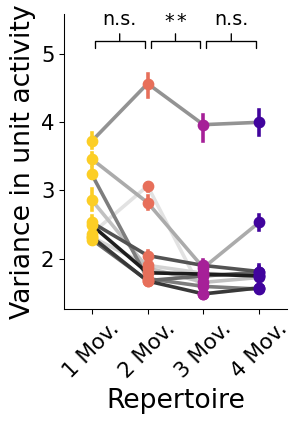

In [16]:
# variance in unit activity
g = dt.compare_measure(measures_df, 'var_rates_total', reps, stats_alternative = 'greater')
g.set_ylabel("\n".join(wrap('Variance in unit activity')))
plt.savefig(SUBFIG_DIR+ '/var_rates_total.pdf', format = 'pdf', bbox_inches = 'tight')

0.1162109375
0.0029296875
0.9345703125


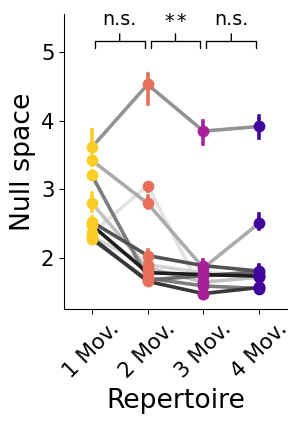

In [17]:
# variance in unit activity in output-null space
g = dt.compare_measure(measures_df, 'var_rates_null_total', reps, stats_alternative = 'greater')
g.set_ylabel("\n".join(wrap('Null space')))
plt.savefig(SUBFIG_DIR+ '/var_rates_null_total.pdf', format = 'pdf', bbox_inches = 'tight')


0.0185546875
0.3125
0.990234375


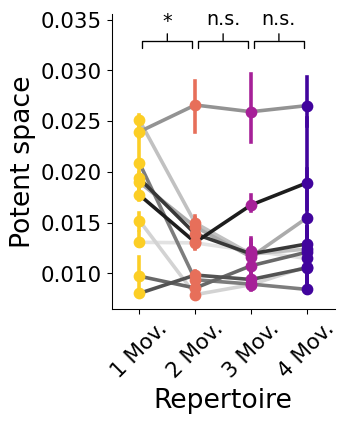

In [18]:
# variance in unit activity in output-potent space
g = dt.compare_measure(measures_df, 'var_rates_potent_total', reps, stats_alternative = 'greater')
g.set_ylabel("\n".join(wrap('Potent space')))
plt.savefig(SUBFIG_DIR+ '/var_rates_potent_total.pdf', format = 'pdf', bbox_inches = 'tight')


0.009765625
0.0244140625
0.65234375


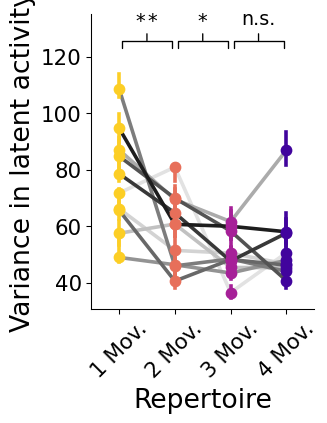

In [19]:
# variance in latent activity
g = dt.compare_measure(measures_df, 'var_pca_total', reps, stats_alternative = 'greater')
g.set_ylabel("\n".join(wrap('Variance in latent activity')))
plt.savefig(SUBFIG_DIR+ '/var_pca_total.pdf', format = 'pdf', bbox_inches = 'tight')


0.1875
0.7216796875
0.001953125


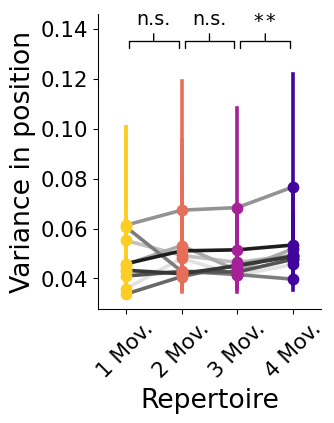

In [20]:
# variance in position
g = dt.compare_measure(measures_df, 'var_pos_total', reps, stats_alternative = 'less')
g.set_ylabel("\n".join(wrap('Variance in position')))
plt.savefig(SUBFIG_DIR+ '/var_position_total.pdf', format = 'pdf', bbox_inches = 'tight')
